# **Worm tracking with trackpy**

# **Load libraries and environment**

In [ ]:
%%bash
MINICONDA_INSTALLER_SCRIPT=Miniconda3-py37_4.12.0-Linux-x86_64.sh
MINICONDA_PREFIX=/usr/local
wget https://repo.continuum.io/miniconda/$MINICONDA_INSTALLER_SCRIPT
chmod +x $MINICONDA_INSTALLER_SCRIPT
./$MINICONDA_INSTALLER_SCRIPT -b -f -p $MINICONDA_PREFIX

In [ ]:
%%bash
conda install --channel defaults conda python=3.7 --yes
conda update --channel defaults --all --yes

In [ ]:
import sys
sys.path

In [4]:
import sys
_ = (sys.path
        .append("/usr/local/lib/python3.7/site-packages"))

In [ ]:
!conda install -c conda-forge trackpy

!conda install -c conda-forge pims

In [ ]:
#conda install -c conda-forge ffmpeg-python # For merging videos
#%pip install ffmpeg-python

In [ ]:
import copy
import collections as coll
import functools as ft
import numpy as np
import cv2
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline

# Optionally, tweak styles.
mpl.rc('figure',  figsize=(10, 5))
mpl.rc('image', cmap='gray')

import pandas as pd
from pandas import DataFrame, Series

import os
import shutil
import glob

import pims
import trackpy as tp
from PIL import Image

from google.colab import drive
drive.mount('/content/drive')


# **Auxiliary Functions**

In [7]:
def delate_all():
  shutil.rmtree('/content/drive/MyDrive/Gusano/Input')
  shutil.rmtree('/content/drive/MyDrive/Gusano/Output')
  shutil.rmtree('/content/drive/MyDrive/Gusano/Output_Video')
  shutil.rmtree('/content/drive/MyDrive/Gusano/Processed_Frames')

def create_all():
  os.mkdir('/content/drive/MyDrive/Gusano/Input')
  os.mkdir('/content/drive/MyDrive/Gusano/Output')
  os.mkdir('/content/drive/MyDrive/Gusano/Output_Video')
  os.mkdir('/content/drive/MyDrive/Gusano/Processed_Frames')

def remove_outside_petri(center, radius_i, radius_j):
    def _inner(i, frame):
        W, H, _ = frame.shape
        I, J = np.ogrid[:W, :H]
        dist_from_center = ((I - center[0])/radius_i)**2 + ((J-center[1])/radius_j)**2
        mask = dist_from_center <= 1
        frame[~mask, :] = 0
    return _inner

def annotate(frame, annotations):
  frame_c = np.zeros([frame.shape[0],frame.shape[1],3],dtype=np.uint8)
  frame_c[:,:,0] = frame
  frame_c[:,:,1] = frame
  frame_c[:,:,2] = frame

  for _,row in annotations.iterrows():
    x,y = int(row['x']), int(row['y'])

    frame_c[x-3: x+3, y-3: y+3] = np.array([0,255,0])

  return frame_c

def extract_frames(PATH, PATH_OUT, radius_i, radius_j, exists):   # Extract frames of the video and save the images
  if exists:
    shutil.rmtree(PATH_OUT) 
  os.mkdir(PATH_OUT)
  capture = cv2.VideoCapture('/content/drive/MyDrive/Gusano/Videos/'+PATH)
  frameNr = 0
  while (True):
      success, frame = capture.read()
      if success:
          remove_outside_petri((686/2, 648/2), radius_i, radius_j)(0, frame)
          cv2.imwrite(PATH_OUT+f'/frame_{frameNr}.jpg', frame)
      else:
          break
      frameNr = frameNr+1
  capture.release()

def load_data(PATH): #Load all the frames
  @pims.pipeline
  def gray(image):
      return image[:, :, 1]  # Take just the green channel
  return gray(pims.open(PATH))

def load_data_1(PATH): #Load all the frames
  @pims.pipeline
  def gray_1(image):
      return image
  return gray_1(pims.open(PATH))

def load_labels(PATH):
    file = open('/content/drive/MyDrive/Gusano/Labels/'+PATH, 'r')
    slice = -1
    ret = {}
    for i, line in enumerate(file.readlines()):
        fields = line.split()
        if i == 0 or fields[7] == slice:
            continue
        true_i = float(fields[6])
        true_j = float(fields[5])
        slice = int(fields[7])
        ret[slice] = (true_i, true_j)
    return ret

def create_output_frames_custom(n, t, PATH, data_frame, exists): # Create annotated frames(n = #frames and t dataframe of annotations)
  if exists:
    shutil.rmtree(PATH)
  os.mkdir(PATH)
  for i in range(0, n):
    cv2.imwrite(PATH+f'/frame_output_{i}.jpg', annotate(data_frame[i], t[t['frame'] == i]))

def create_output_video_custome(PATH, PATH_OUT): # Create final video with the tracking in the PATH_OUT
  img_array = []
  for filename in glob.glob(PATH+'*.jpg'):
      img = cv2.imread(filename)
      height, width, layers = img.shape
      size = (width,height)
      img_array.append(img)
  out_1 = cv2.VideoWriter(PATH_OUT,cv2.VideoWriter_fourcc(*'DIVX'), 15, size)
  for i in range(len(img_array)):
      out_1.write(img_array[i])
  out_1.release()

def create_output_video_parts(PATH, PATH_OUT, n, m): # Create final video with the tracking in the indicated interval of frames
  img_array = []
  abc = glob.glob(PATH+'*.jpg')
  for filename in abc[n:m]:
      img = cv2.imread(filename)
      height, width, layers = img.shape
      size = (width,height)
      img_array.append(img)
  out_1 = cv2.VideoWriter(PATH_OUT,cv2.VideoWriter_fourcc(*'DIVX'), 15, size)
  for i in range(len(img_array)):
      out_1.write(img_array[i])
  out_1.release()

def lowpass_all(n, sigma, PATH, data_frame, exists):
  if exists:
    shutil.rmtree(PATH)
  os.mkdir(PATH)
  for i in range(0, n-1):
    im_f = tp.preprocessing.lowpass(data_frame[i], sigma)
    pil_img = Image.fromarray(im_f.astype(np.uint8))
    pil_img.save(PATH+f'/frame_processed_{i}.jpg')

def bandpass_all(n, lshort, llong, PATH, data_frame, exists):
  if exists:
    shutil.rmtree(PATH)
  os.mkdir(PATH)
  for i in range (0, n-1):
    im_f = tp.preprocessing.bandpass(data_frame[i], lshort, llong)
    pil_img = Image.fromarray(im_f.astype(np.uint8))
    pil_img.save(PATH+f'/frame_processed_{i}.jpg')

def coordinate_refinment(f, n, data_frame):
  R = pd.DataFrame()
  for i in range(0, n-1):
    r = tp.refine_com(data_frame[i], data_frame[i], dist_refinment, f[f['frame']==i]) # Check the distance
    r['frame'] = i
    R = pd.concat([R, r])
  return R

def evaluation_mean_dist(n, data_frame, l):
  mean_dist = 0
  n_labels = 0 # No all keys exists
  for i in range(0, n-1):
    if (i+1 in l and len(data_frame[data_frame['frame']==i]) > 0):
      n_labels += 1
      mean_dist += abs((l[i + 1][0] - float(data_frame[data_frame['frame']==i].x)) + (l[i+1][1] - float(data_frame[data_frame['frame']==i].y))) # Manhattan distance
  return mean_dist/n_labels

def evaluation_mean_dist_R(n, data_frame, l): # This is for the evaluation of the coordinate refinment
  mean_dist = 0
  n_labels = 0 # No all keys exists
  for i in range(0, n-1):
    if (i+1 in l and i in data_frame.x):
      n_labels += 1
      mean_dist += abs((l[i + 1][0] - float(data_frame.x[i])) + (l[i+1][1] - float(data_frame.y[i]))) # Manhattan distance
  return mean_dist/n_labels

# **Load Data and Frames**

In [ ]:
create_all()

In [ ]:
delate_all()

In [ ]:
# Be careful with the True and False

extract_frames('pw1_A1_0315_part1.avi', '/content/drive/MyDrive/Gusano/Input/V1' ,300, 300, False)
extract_frames('pw1_A1_0315_part2.avi', '/content/drive/MyDrive/Gusano/Input/V2' ,300, 300, False)
extract_frames('pw1_A1_0315_part3.avi', '/content/drive/MyDrive/Gusano/Input/V3' ,300, 300, False)

In [8]:
framesV1 = load_data('/content/drive/MyDrive/Gusano/Input/V1/*.jpg')
framesV2 = load_data('/content/drive/MyDrive/Gusano/Input/V2/*.jpg')
framesV3 = load_data('/content/drive/MyDrive/Gusano/Input/V3/*.jpg')

In [9]:
# First we have to create the processed frames in the 'Preproccesing' section

frames_p_V1 = load_data_1('/content/drive/MyDrive/Gusano/Processed_Frames/V1/*.jpg')
frames_p_V2 = load_data_1('/content/drive/MyDrive/Gusano/Processed_Frames/V2/*.jpg')
frames_p_V3 = load_data_1('/content/drive/MyDrive/Gusano/Processed_Frames/V3/*.jpg')

In [10]:
labels_1 = load_labels('pw1_A1_0315_part1.txt')
labels_2 = load_labels('pw1_A1_0315_part2.txt')
labels_3 = load_labels('pw1_A1_0315_part3.txt')

# **Global Constants**

In [11]:
# Global Constants
N1, M1 = framesV1[0].shape
n_frames1 = len(framesV1)
N2, M2 = framesV2[0].shape
n_frames2 = len(framesV2)
N3, M3 = framesV3[0].shape
n_frames3 = len(framesV3)

mask_size = 19
n_annotations = 100
max_disp = 7
frames_of_memory = 50
survive_frames = 5
dist_refinment = 9

# **Preprocessing**

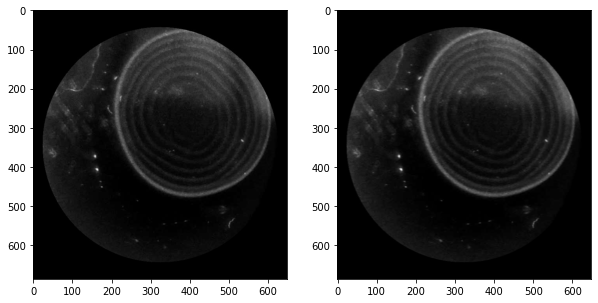

In [ ]:
# Convolve with a Gaussian to remove short-wavelength noise. 
# Testing

im_f = tp.preprocessing.lowpass(framesV3[0], sigma=(0,1))

ims = [framesV3[0], im_f]
fig, ax = plt.subplots(1, 2)
for i in range(2):
    ax[i].imshow(ims[i])

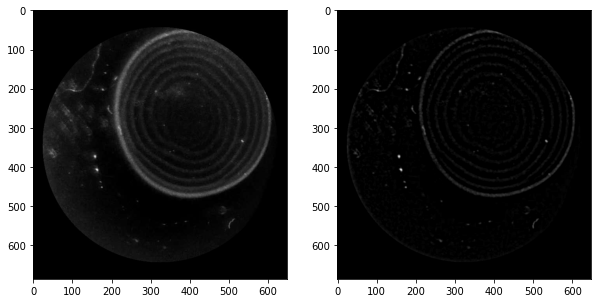

In [ ]:
# Convolve with a Gaussian to remove short-wavelength noise and subtract out long-wavelength variations by subtracting a running average.
# Testing

im_f = tp.preprocessing.bandpass(framesV3[11750], lshort = 1, llong = 19) 

ims = [framesV3[11750], im_f]
fig, ax = plt.subplots(1, 2)
for i in range(2):
    ax[i].imshow(ims[i])

In [ ]:
# Lowpass all frames and save them

lowpass_all(n_frames1, (1,1), '/content/drive/MyDrive/Gusano/Processed_Frames/V1', framesV1, False) # Check entry parameters

lowpass_all(n_frames2, (1,1), '/content/drive/MyDrive/Gusano/Processed_Frames/V2', framesV2, False) # Check entry parameters

lowpass_all(n_frames3, (1,1), '/content/drive/MyDrive/Gusano/Processed_Frames/V3', framesV3, False) # Check entry parameters

In [ ]:
# Bandpass all frames and save them

bandpass_all(n_frames1, 0, 19, '/content/drive/MyDrive/Gusano/Processed_Frames/V1', framesV1, False) # Check entry parameters

bandpass_all(n_frames2, 0, 19, '/content/drive/MyDrive/Gusano/Processed_Frames/V2', framesV2, False) # Check entry parameters

bandpass_all(n_frames3, 0, 19, '/content/drive/MyDrive/Gusano/Processed_Frames/V3', framesV3, False) # Check entry parameters

# **Exploratory Analysis**

**General**

In [ ]:
framesV3

(ImageSequence,) processed through proc_func. Original repr:
    <Frames>
    Source: /content/drive/MyDrive/Gusano/Input/V3/*.jpg
    Length: 12754 frames
    Frame Shape: (686, 648, 3)
    Pixel Datatype: uint8

In [ ]:
frames_p_V3

(ImageSequence,) processed through proc_func. Original repr:
    <Frames>
    Source: /content/drive/MyDrive/Gusano/Processed_Frames/V3/*.jpg
    Length: 12753 frames
    Frame Shape: (686, 648)
    Pixel Datatype: uint8

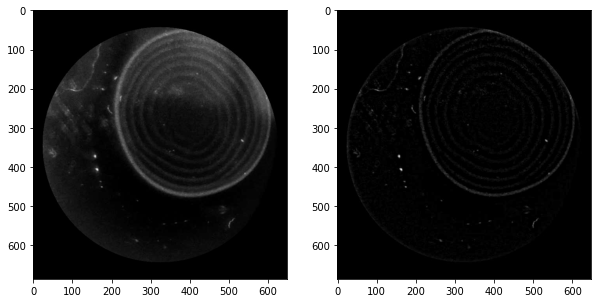

In [ ]:
ims = [framesV3[0], frames_p_V3[0]]
fig, ax = plt.subplots(1, 2)
for i in range(2):
    ax[i].imshow(ims[i])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1b97ea0d90>,
      dtype=object)

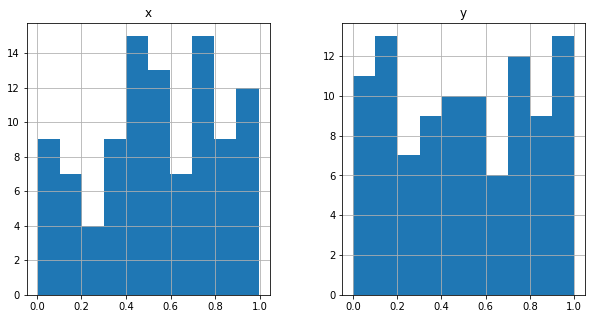

In [ ]:
f_1 = tp.locate(framesV3[11750], mask_size, invert=False, topn=n_annotations, preprocess=True)

tp.subpx_bias(f_1) # Check subpixel accuracy (no dip in the middle)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1b96c71820>,
      dtype=object)

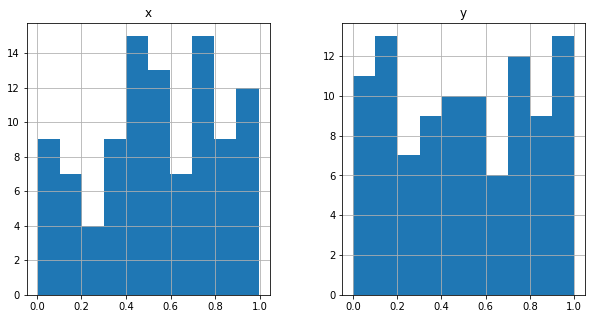

In [ ]:
f_1_p = tp.locate(frames_p_V3[11750], mask_size, invert=False, topn=n_annotations, preprocess=True)

tp.subpx_bias(f_1) # Check subpixel accuracy (no dip in the middle)

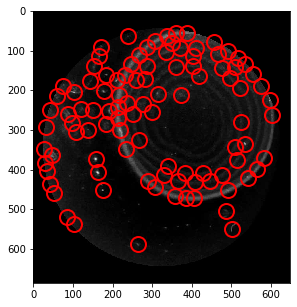

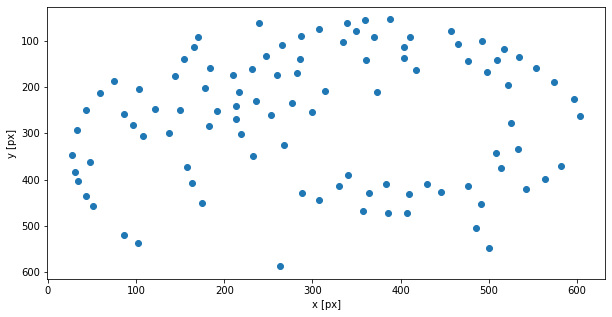

,y,x,mass,size,ecc,signal,raw_mass,ep,frame
174,427.449853,445.994135,662.485795,5.088196,0.304462,10.490977,3087.0,0.002333,11750
30,138.804220,286.372216,662.874349,4.897603,0.388006,11.268087,4766.0,0.001511,11750
4,62.687902,238.972531,664.817123,4.371752,0.156180,21.759064,2060.0,0.003496,11750
196,537.629350,101.540603,669.868334,5.783256,0.330012,7.771094,2812.0,0.002561,11750
164,408.746960,383.436595,671.033999,5.308164,0.355960,8.936759,2524.0,0.002853,11750


In [ ]:
tp.annotate(f_1, framesV3[11750])

tp.scatter(f_1)

f_1.head()

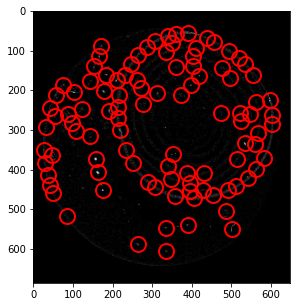

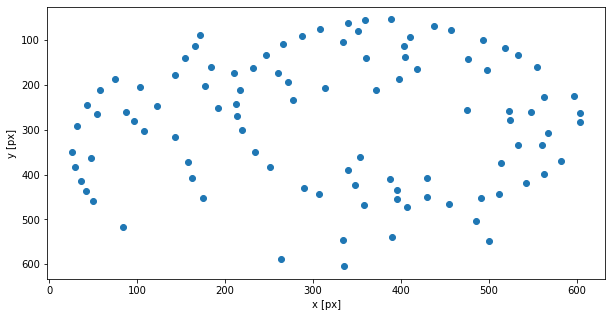

,y,x,mass,size,ecc,signal,raw_mass,ep,frame
31,138.580595,404.394366,451.804441,4.914130,0.442471,9.191640,878.0,0.005061,11750
59,194.184149,271.968143,454.986162,5.437788,0.439609,6.363443,737.0,0.006031,11750
210,517.599231,84.196154,459.581982,5.447088,0.546354,6.363443,917.0,0.004846,11750
138,334.073282,560.512214,463.117228,5.372321,0.549661,9.191640,718.0,0.006191,11750
82,228.128419,563.192249,465.238376,4.544110,0.429184,8.131066,679.0,0.006547,11750


In [ ]:
tp.annotate(f_1_p, frames_p_V3[11750])

tp.scatter(f_1_p)

f_1_p.head()

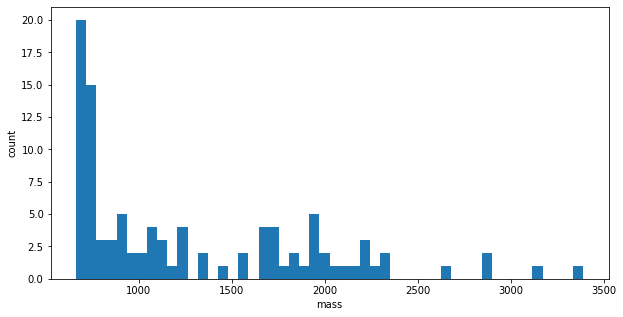

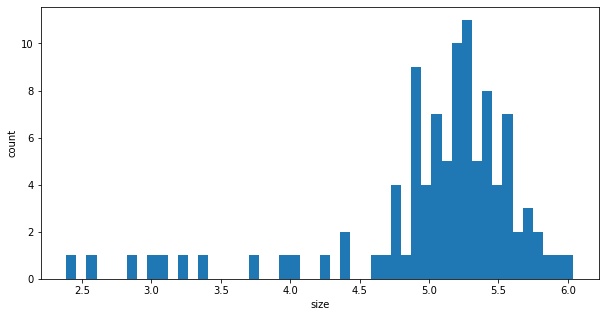

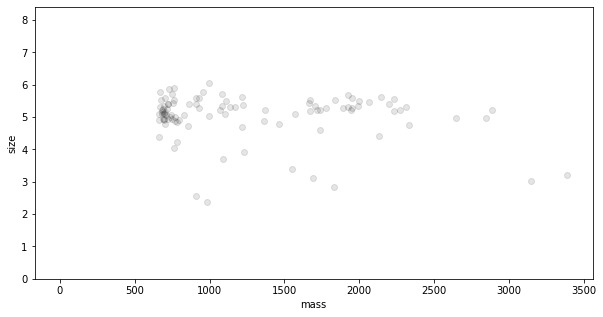

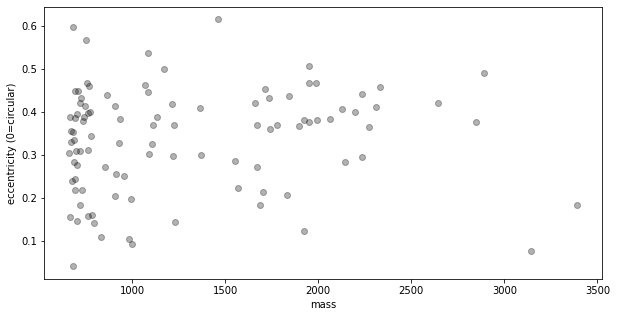

,y,x,mass,size,ecc,signal,raw_mass,ep,frame
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.0
mean,266.105475,304.013368,1288.218199,5.026584,0.336098,21.658040,6048.420000,0.001462,11750.0
std,137.679656,162.643114,656.723679,0.703389,0.120094,16.385662,2861.187891,0.000651,0.0
min,54.053538,27.727891,662.485795,2.385251,0.040441,6.993985,2060.000000,0.000515,11750.0
25%,142.623572,173.618438,735.436943,4.922675,0.254893,10.879532,3900.500000,0.000920,11750.0
50%,249.672719,293.741382,1034.915492,5.213269,0.367733,17.484962,5063.000000,0.001422,11750.0
75%,392.288586,433.690610,1748.981926,5.397298,0.419263,24.673225,7824.750000,0.001846,11750.0
max,587.518717,603.224134,3388.974253,6.041233,0.614804,98.692898,13979.000000,0.003496,11750.0


In [ ]:
# This measures are from the top 100 annotations and the single frame

fig, ax = plt.subplots()
ax.hist(f_1['mass'], bins=50)
ax.set(xlabel='mass', ylabel='count')

fig, ax = plt.subplots()
ax.hist(f_1['size'], bins=50)
ax.set(xlabel='size', ylabel='count')

fig, ax = plt.subplots()
ax.hist(f_1['ecc'], bins=50)
ax.set(xlabel='ecc', ylabel='count')

tp.mass_size(f_1) 

tp.mass_ecc(f_1)

f_1.describe()

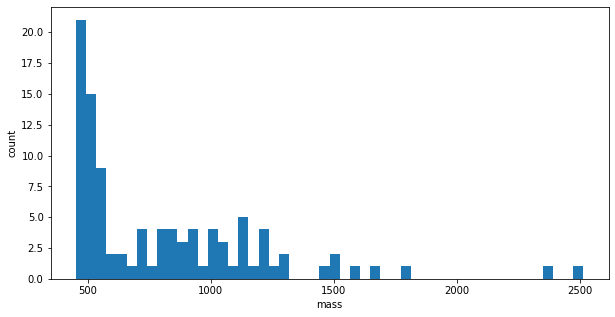

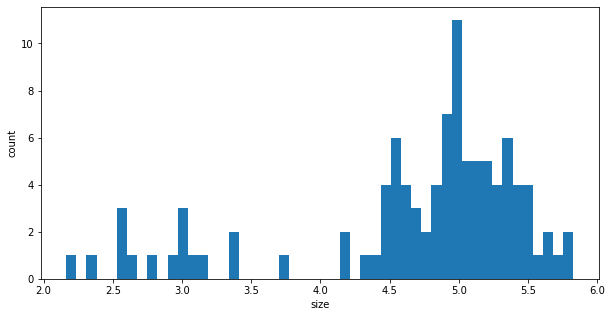

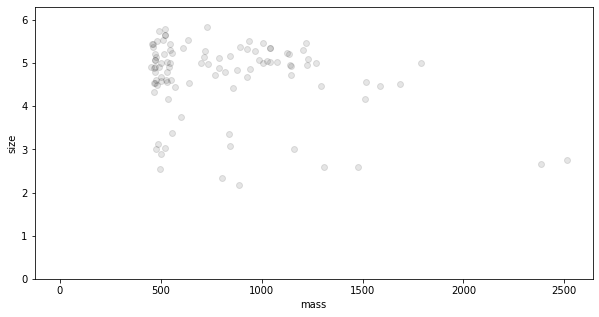

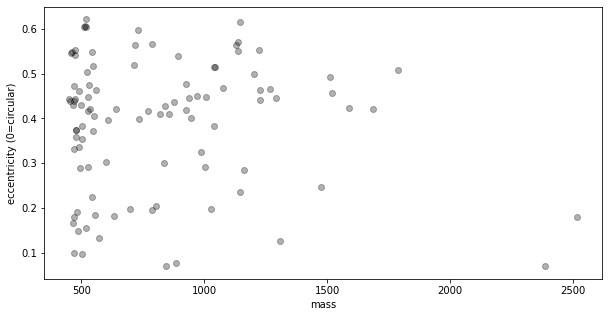

,y,x,mass,size,ecc,signal,raw_mass,ep,frame
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.0
mean,282.020945,319.631967,816.871621,4.675422,0.390126,18.814579,1494.340000,0.003639,11750.0
std,142.224171,169.036004,404.128785,0.871247,0.145601,14.947819,707.794301,0.001539,0.0
min,53.871516,26.586362,451.804441,2.163228,0.069125,6.009918,664.000000,0.001205,11750.0
25%,163.177896,177.055104,502.358459,4.524715,0.291946,9.456783,889.500000,0.002217,11750.0
50%,261.310087,337.544937,705.635105,4.941490,0.422408,14.494509,1271.500000,0.003494,11750.0
75%,407.170656,461.116130,1031.849931,5.229754,0.494978,21.565001,2003.000000,0.004996,11750.0
max,605.097893,603.460156,2514.266967,5.827381,0.621647,90.148773,3685.000000,0.006695,11750.0


In [ ]:
# This measures are from the top 100 annotations and a single frame - processed frames

fig, ax = plt.subplots()
ax.hist(f_1_p['mass'], bins=50)
ax.set(xlabel='mass', ylabel='count')

fig, ax = plt.subplots()
ax.hist(f_1_p['size'], bins=50)
ax.set(xlabel='size', ylabel='count')

fig, ax = plt.subplots()
ax.hist(f_1_p['ecc'], bins=50)
ax.set(xlabel='ecc', ylabel='count')

tp.mass_size(f_1_p)

tp.mass_ecc(f_1_p)

f_1_p.describe()

In [ ]:
tp.quiet() # Turn off progress reports for best performance
f = tp.batch(framesV3[:500], mask_size, invert=False, topn=n_annotations, preprocess=True)

In [ ]:
tp.quiet() # Turn off progress reports for best performance
f_p = tp.batch(framesV3[:500], mask_size, invert=False, topn=n_annotations, preprocess=True)

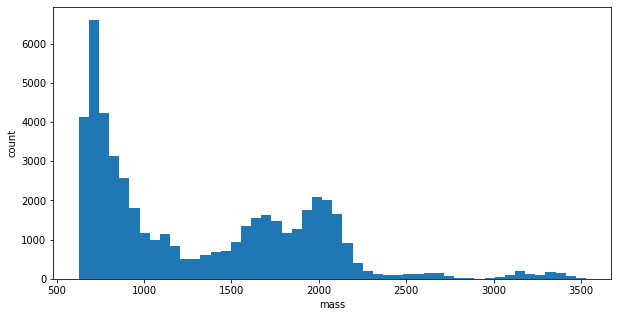

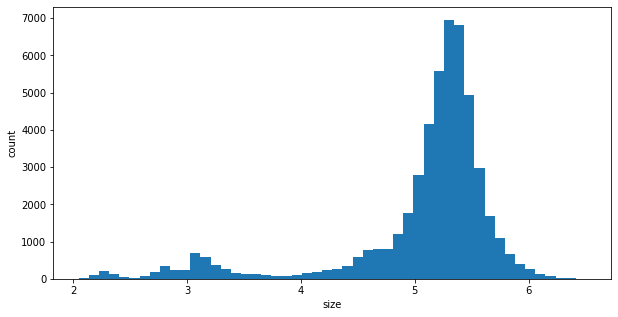

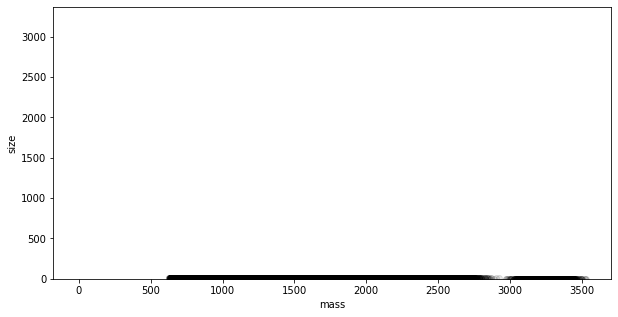

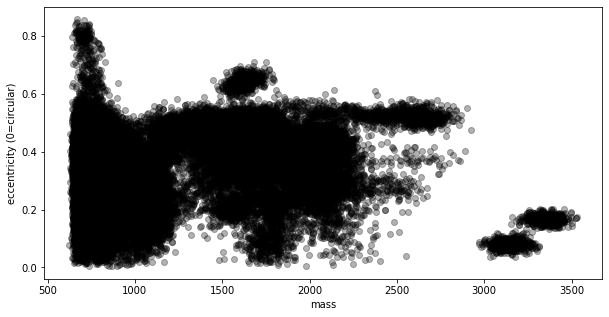

,y,x,mass,size,ecc,signal,raw_mass,ep,frame
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,264.061555,311.320774,1320.421432,5.071604,0.343767,21.744021,7096.054920,0.001778,249.500000
std,140.401355,169.658504,613.879413,0.697410,0.126809,15.854989,2799.899816,0.001046,144.338722
min,46.562828,27.256201,625.415895,2.049116,0.003182,5.368730,1959.000000,0.000303,0.000000
25%,142.585338,168.683228,763.309418,5.028793,0.255118,11.108048,4494.750000,0.001043,124.750000
50%,245.181885,309.457981,1107.436320,5.271250,0.361578,18.674085,7364.000000,0.001454,249.500000
75%,376.820439,469.416498,1832.355126,5.431563,0.433643,24.538765,8984.000000,0.002214,374.250000
max,638.136747,605.156733,3529.265231,6.504102,0.857281,109.297019,14406.000000,0.009358,499.000000


In [ ]:
# This measures are from the top 100 annotations and all frames

fig, ax = plt.subplots()
ax.hist(f['mass'], bins=50)
ax.set(xlabel='mass', ylabel='count')

fig, ax = plt.subplots()
ax.hist(f['size'], bins=50)
ax.set(xlabel='size', ylabel='count')

fig, ax = plt.subplots()
ax.hist(f['ecc'], bins=50)
ax.set(xlabel='ecc', ylabel='count')

tp.mass_size(f) 

tp.mass_ecc(f)

f.describe()

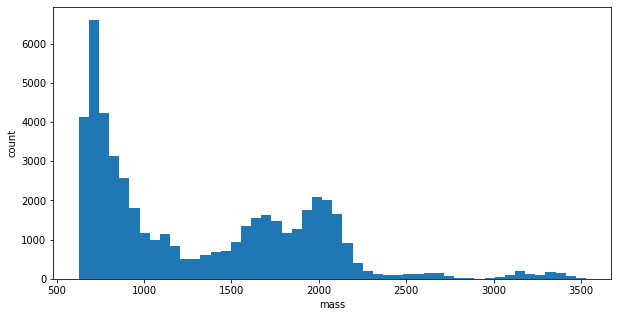

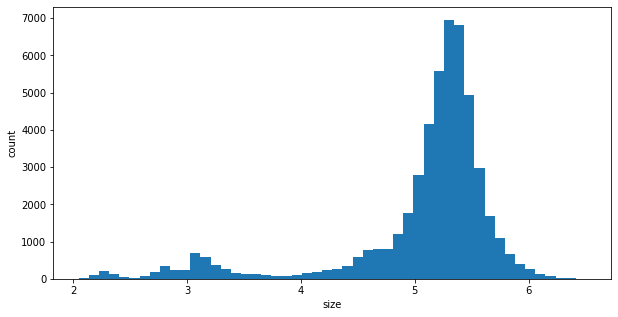

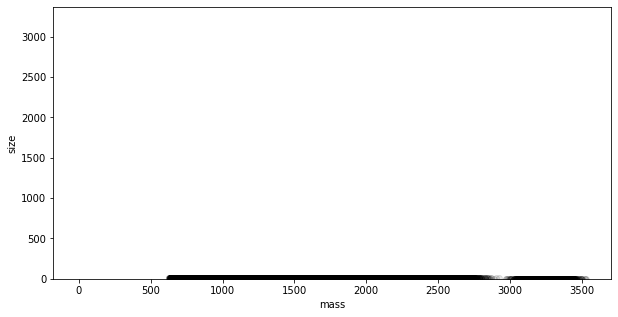

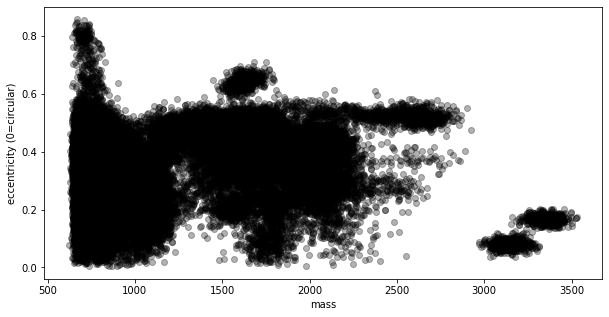

,y,x,mass,size,ecc,signal,raw_mass,ep,frame
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,264.061555,311.320774,1320.421432,5.071604,0.343767,21.744021,7096.054920,0.001778,249.500000
std,140.401355,169.658504,613.879413,0.697410,0.126809,15.854989,2799.899816,0.001046,144.338722
min,46.562828,27.256201,625.415895,2.049116,0.003182,5.368730,1959.000000,0.000303,0.000000
25%,142.585338,168.683228,763.309418,5.028793,0.255118,11.108048,4494.750000,0.001043,124.750000
50%,245.181885,309.457981,1107.436320,5.271250,0.361578,18.674085,7364.000000,0.001454,249.500000
75%,376.820439,469.416498,1832.355126,5.431563,0.433643,24.538765,8984.000000,0.002214,374.250000
max,638.136747,605.156733,3529.265231,6.504102,0.857281,109.297019,14406.000000,0.009358,499.000000


In [ ]:
# This measures are from the top 100 annotations and all frames - processed frames

fig, ax = plt.subplots()
ax.hist(f_p['mass'], bins=50)
ax.set(xlabel='mass', ylabel='count')

fig, ax = plt.subplots()
ax.hist(f_p['size'], bins=50)
ax.set(xlabel='size', ylabel='count')

fig, ax = plt.subplots()
ax.hist(f_p['ecc'], bins=50)
ax.set(xlabel='ecc', ylabel='count')

tp.mass_size(f_p) 

tp.mass_ecc(f_p)

f_p.describe()

**Single Worm**

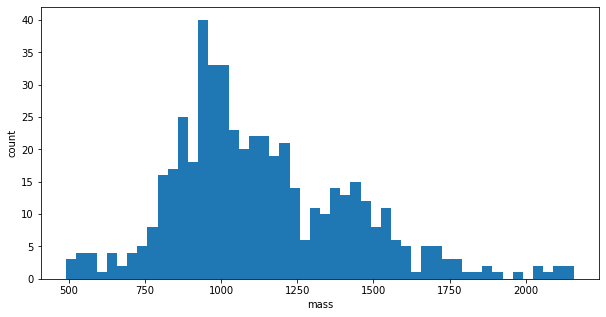

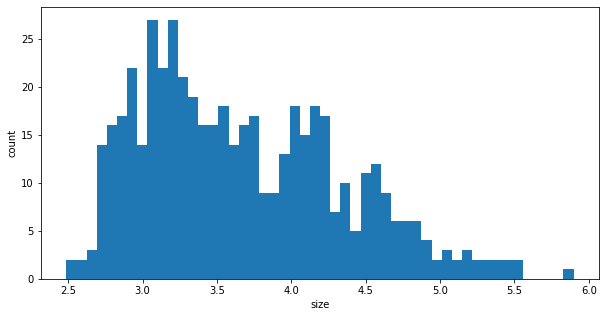

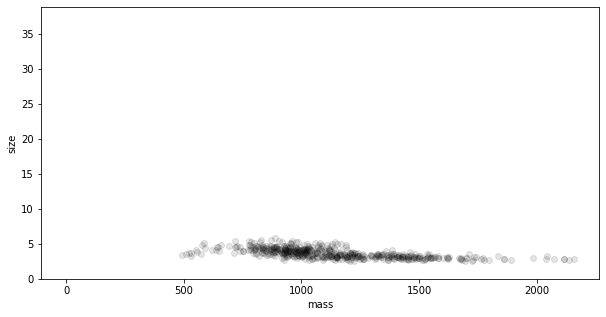

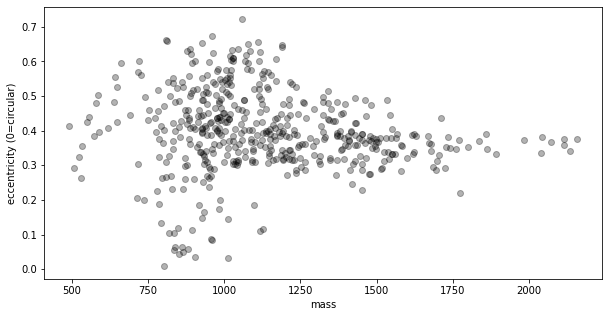

,y,x,mass,size,ecc,signal,raw_mass,ep,frame,particle
count,499.000000,499.000000,499.000000,499.000000,499.000000,499.000000,499.000000,499.000000,499.000000,499.0
mean,220.279707,225.408527,1133.556976,3.673564,0.397682,44.463719,2083.482966,0.002829,249.152305,10.0
std,2.348907,2.616539,294.864044,0.674223,0.117427,16.081317,316.755694,0.000593,144.417278,0.0
min,217.463734,219.739470,491.502598,2.487546,0.008048,16.914023,1149.000000,0.001597,0.000000,10.0
25%,218.414741,223.716123,931.935165,3.115980,0.333558,31.087633,1892.000000,0.002399,124.500000,10.0
50%,219.310490,225.571312,1069.996897,3.547538,0.389119,41.699463,2061.000000,0.002796,249.000000,10.0
75%,221.570744,227.545122,1323.584635,4.146185,0.468005,54.319473,2257.000000,0.003188,373.500000,10.0
max,228.101721,230.157822,2157.093629,5.897359,0.721191,96.687585,3269.000000,0.005268,499.000000,10.0


In [ ]:
# First we have to create de Data_Frame T_5 or T_6 in the 'Create Video' section (having find the annotation of the worm)
# Here we have the data of the worm in all frames

fig, ax = plt.subplots()
ax.hist(T_6['mass'], bins=50)
ax.set(xlabel='mass', ylabel='count')

fig, ax = plt.subplots()
ax.hist(T_6['size'], bins=50)
ax.set(xlabel='size', ylabel='count')

fig, ax = plt.subplots()
ax.hist(T_6['ecc'], bins=50)
ax.set(xlabel='ecc', ylabel='count')

tp.mass_size(T_6) 

tp.mass_ecc(T_6)

T_6.describe()

# **Annotation**

### **Locate Features**


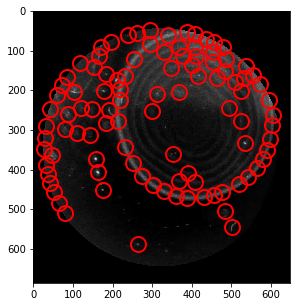

In [ ]:
# Annotate single frame

tp.annotate(f[f['frame'] == 0], framesV3[0])

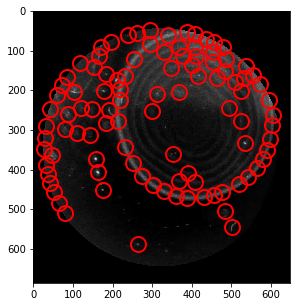

In [ ]:
# Annotate single frame - preprocessed frame

tp.annotate(f_p[f_p['frame'] == 0], framesV3[0])

In [ ]:
f.describe()

,y,x,mass,size,ecc,signal,raw_mass,ep,frame
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,264.061555,311.320774,1320.421432,5.071604,0.343767,21.744021,7096.054920,0.001778,249.500000
std,140.401355,169.658504,613.879413,0.697410,0.126809,15.854989,2799.899816,0.001046,144.338722
min,46.562828,27.256201,625.415895,2.049116,0.003182,5.368730,1959.000000,0.000303,0.000000
25%,142.585338,168.683228,763.309418,5.028793,0.255118,11.108048,4494.750000,0.001043,124.750000
50%,245.181885,309.457981,1107.436320,5.271250,0.361578,18.674085,7364.000000,0.001454,249.500000
75%,376.820439,469.416498,1832.355126,5.431563,0.433643,24.538765,8984.000000,0.002214,374.250000
max,638.136747,605.156733,3529.265231,6.504102,0.857281,109.297019,14406.000000,0.009358,499.000000


In [ ]:
f_p.describe()

,y,x,mass,size,ecc,signal,raw_mass,ep,frame
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,264.061555,311.320774,1320.421432,5.071604,0.343767,21.744021,7096.054920,0.001778,249.500000
std,140.401355,169.658504,613.879413,0.697410,0.126809,15.854989,2799.899816,0.001046,144.338722
min,46.562828,27.256201,625.415895,2.049116,0.003182,5.368730,1959.000000,0.000303,0.000000
25%,142.585338,168.683228,763.309418,5.028793,0.255118,11.108048,4494.750000,0.001043,124.750000
50%,245.181885,309.457981,1107.436320,5.271250,0.361578,18.674085,7364.000000,0.001454,249.500000
75%,376.820439,469.416498,1832.355126,5.431563,0.433643,24.538765,8984.000000,0.002214,374.250000
max,638.136747,605.156733,3529.265231,6.504102,0.857281,109.297019,14406.000000,0.009358,499.000000


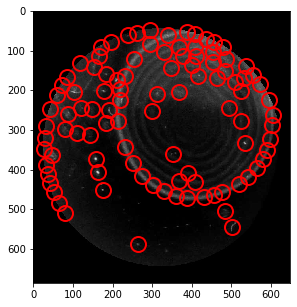

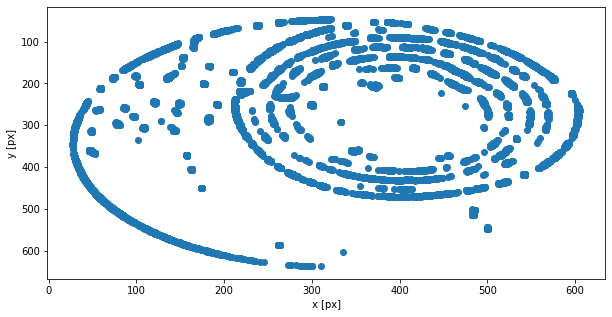

,y,x,mass,size,ecc,signal,raw_mass,ep,frame,particle
0,201.549824,525.497069,669.829684,6.013662,0.494539,9.815793,5791.0,0.001541,0,0
72,382.771281,250.541322,1900.337438,5.286717,0.404372,20.416849,9182.0,0.000972,0,1
71,57.958584,408.703872,1896.018490,5.183004,0.551471,32.588431,8845.0,0.001009,0,2
70,262.508658,604.223868,1881.883748,5.747594,0.235358,18.453690,10508.0,0.000849,0,3
69,332.674564,533.794960,1822.988993,2.974332,0.239133,62.035809,6696.0,0.001332,0,4


In [ ]:
# Link frames

tp.quiet()
t = tp.link(f, 19, memory=100)
tp.annotate(t[t['frame'] == 0], framesV3[0])
tp.scatter(t)
t.head()

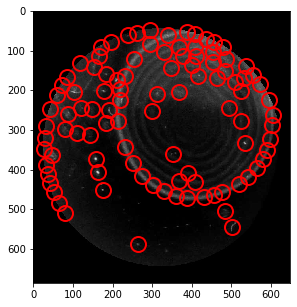

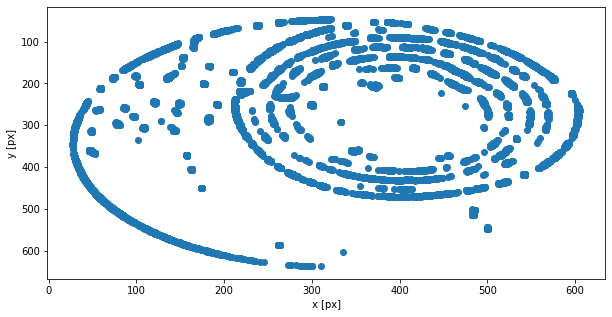

,y,x,mass,size,ecc,signal,raw_mass,ep,frame,particle
0,201.549824,525.497069,669.829684,6.013662,0.494539,9.815793,5791.0,0.001541,0,0
72,382.771281,250.541322,1900.337438,5.286717,0.404372,20.416849,9182.0,0.000972,0,1
71,57.958584,408.703872,1896.018490,5.183004,0.551471,32.588431,8845.0,0.001009,0,2
70,262.508658,604.223868,1881.883748,5.747594,0.235358,18.453690,10508.0,0.000849,0,3
69,332.674564,533.794960,1822.988993,2.974332,0.239133,62.035809,6696.0,0.001332,0,4


In [ ]:
# Link frames - preprocessed frame

tp.quiet()
t_p = tp.link(f_p, 19, memory=100)
tp.annotate(t_p[t_p['frame'] == 0], framesV3[0])
tp.scatter(t_p)
t.head()

In [ ]:
t.describe()

,y,x,mass,size,ecc,signal,raw_mass,ep,frame,particle
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,264.061555,311.320774,1320.421432,5.071604,0.343767,21.744021,7096.054920,0.001778,249.500000,81.271180
std,140.401355,169.658504,613.879413,0.697410,0.126809,15.854989,2799.899816,0.001046,144.338722,61.107228
min,46.562828,27.256201,625.415895,2.049116,0.003182,5.368730,1959.000000,0.000303,0.000000,0.000000
25%,142.585338,168.683228,763.309418,5.028793,0.255118,11.108048,4494.750000,0.001043,124.750000,32.000000
50%,245.181885,309.457981,1107.436320,5.271250,0.361578,18.674085,7364.000000,0.001454,249.500000,68.000000
75%,376.820439,469.416498,1832.355126,5.431563,0.433643,24.538765,8984.000000,0.002214,374.250000,115.000000
max,638.136747,605.156733,3529.265231,6.504102,0.857281,109.297019,14406.000000,0.009358,499.000000,294.000000


In [ ]:
t_p.describe()

,y,x,mass,size,ecc,signal,raw_mass,ep,frame,particle
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,264.061555,311.320774,1320.421432,5.071604,0.343767,21.744021,7096.054920,0.001778,249.500000,81.271180
std,140.401355,169.658504,613.879413,0.697410,0.126809,15.854989,2799.899816,0.001046,144.338722,61.107228
min,46.562828,27.256201,625.415895,2.049116,0.003182,5.368730,1959.000000,0.000303,0.000000,0.000000
25%,142.585338,168.683228,763.309418,5.028793,0.255118,11.108048,4494.750000,0.001043,124.750000,32.000000
50%,245.181885,309.457981,1107.436320,5.271250,0.361578,18.674085,7364.000000,0.001454,249.500000,68.000000
75%,376.820439,469.416498,1832.355126,5.431563,0.433643,24.538765,8984.000000,0.002214,374.250000,115.000000
max,638.136747,605.156733,3529.265231,6.504102,0.857281,109.297019,14406.000000,0.009358,499.000000,294.000000


### **Filter trajectories**

In [ ]:
# First way of filtering

t1 = tp.filter_stubs(t, 100) 

print('Before:', t['particle'].nunique())
print('After:', t1['particle'].nunique())

tp.annotate(t1[t1['frame'] == 0], framesV3[0])
tp.scatter(t1)

In [ ]:
# First way of filtering - preprocessed frames

t1_p = tp.filter_stubs(t_p, 100) 

print('Before:', t_p['particle'].nunique())
print('After:', t1['particle'].nunique())

tp.annotate(t1[t1['frame'] == 0], framesV3[0])
tp.scatter(t1)

In [ ]:
# Second way of filtering

t1 = tp.filtering.filter_clusters(t, 0.75) # Quantile from which to cut off (mean of the size particle)

print('Before:', t['particle'].nunique())
print('After:', t1['particle'].nunique())

tp.annotate(t1[t1['frame'] == 0], framesV3[0])
tp.scatter(t1)

In [ ]:
# Second way of filtering - preprocessed frames

t1_p = tp.filtering.filter_clusters(t, 0.75) # Quantile from which to cut off (mean of the size particle)

print('Before:', t['particle'].nunique())
print('After:', t1['particle'].nunique())

tp.annotate(t1[t1['frame'] == 0], framesV3[0])
tp.scatter(t1)

In [ ]:
t1.describe()

In [ ]:
t1_p.describe()

In [ ]:
# Custome filtering (With the data of the exploratory analysis)

t2 = t1[((t1['mass'] > 1320.421432) & (t1['size'] > 5.071604) & (t1['ecc'] < 0.343767))] # Filter by mean or quanil, etc

tp.annotate(t2[t2['frame'] == 0], framesV3[0])
tp.scatter(t2)

In [ ]:
# Custome filtering (With the data of the exploratory analysis) - preprocessed frames

t2_p = t1_p[((t1_p['mass'] > 1320.421432) & (t1_p['size'] > 5.071604) & (t1_p['ecc'] < 0.343767))] # Filter by mean or quantil, etc

tp.annotate(t2_p[t2_p['frame'] == 0], framesV3[0])
tp.scatter(t2_p)

In [ ]:
t2.describe()

In [ ]:
t2_p.describe()

In [ ]:
# Visualize some frames
for i in range(0,499):
  tp.annotate(t2[t2['frame'] == i], framesV3[i])

In [ ]:
# Visualize some frames - preprocessed frames
for i in range(0,499):
  tp.annotate(t2_p[t2_p['frame'] == i], framesV3[i])

In [ ]:
# Coordinate refinment - (test)

R = pd.DataFrame()
for i in range(0, 499):
  r = tp.refine_com(framesV3[i], framesV3[i], 9, t[t['frame']==i]) # Check the distance
  r['frame'] = i
  R = pd.concat([R, r])

R

# Another option if overlapping: tp.trackpy.refine_leastsq()

# **Create Video**

### Minimum distance to the origin

In [27]:
# Find the closest trajectory respecting the first position of the worm (manual, automatize)
# Firs we have to create de DataFrames

# Coordinates of the first frame
initial_j, initial_i = labels_3[1] #Grirar

m = T_3[T_3['frame']==0] 

I = []
J = []

for i in range(0, m.shape[0]):
  I.append(initial_i)
  J.append(initial_j)

dist_man = abs((m['x'] - I) + (m['y'] - J)) 

#dist_eucl = (t2['x'] - inicial_i)**2 + (t2['y'] - inicial_j)**2

m['dist'] = dist_man

print(m.dist.describe())

count     43.000000
mean     179.317981
std      164.593138
min        4.843084
25%       58.439061
50%      141.379547
75%      246.413648
max      598.612994
Name: dist, dtype: float64


<ipython-input-27-dfb67c71a4b3>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m['dist'] = dist_man


In [28]:
m = m[m.dist < 5]
m

,y,x,mass,size,ecc,signal,raw_mass,ep,frame,particle,dist
frame,,,,,,,,,,,
0,222.959422,219.822494,2119.033297,5.701113,0.116099,36.90738,13347.0,0.000668,0,34,4.843084


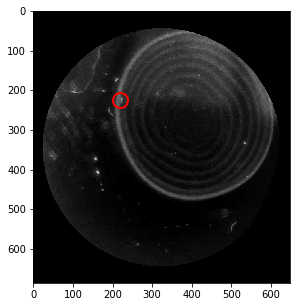

In [29]:
tp.annotate(m, framesV3[0])

### Testing

In [12]:
# Try different dataframes

tp.quiet()
F_1 = tp.batch(framesV3[:500], mask_size, invert=False, topn=n_annotations, preprocess=True) # All annotations no preprocessing
F_2 = tp.batch(frames_p_V3[:500], mask_size, invert=False, topn=n_annotations, preprocess=True) # All annotations preprocessing

In [13]:
T_1 = tp.link(F_1, 19, memory=100) # Linking no preprocessing
T_2 = tp.link(F_2, 19, memory=100) # Linking preprocessing

In [14]:
# Try more filtering methods (Do a custome filtering method!!)

T_3 = tp.filtering.filter_clusters(T_1, 0.5) # Filtering by link no preprocessing
T_4 = tp.filtering.filter_clusters(T_2, 0.5) # Filtering by link preprocessing

T_5 = T_3[T_3.particle == 34] # Closest to initial point no preprocessing (Automate or Threshold of min dist)
T_6 = T_4[T_4.particle == 10] # Closest to initial point preprocessing (Automate or Threshold of min dist)

T_7 = coordinate_refinment(T_3, 500, framesV3) # Coordinate refinment T_3
T_8 = coordinate_refinment(T_4, 500, framesV3) # Coordinate refinment T_4

T_9 = coordinate_refinment(T_5, 500, framesV3) # Coordinate refinment T_5
T_10 = coordinate_refinment(T_6, 500, framesV3) # Coordinate refinment T_6

In [ ]:
# Create output frames annotated
# Remember to choose False or True correctly

create_output_frames_custom(500, T_1, '/content/drive/MyDrive/Gusano/Output/T_1', framesV3, True)

create_output_frames_custom(500, T_2, '/content/drive/MyDrive/Gusano/Output/T_2', framesV3, True)

create_output_frames_custom(500, T_3, '/content/drive/MyDrive/Gusano/Output/T_3', framesV3, True)

create_output_frames_custom(500, T_4, '/content/drive/MyDrive/Gusano/Output/T_4', framesV3, True)

create_output_frames_custom(500, T_5, '/content/drive/MyDrive/Gusano/Output/T_5', framesV3, True)

create_output_frames_custom(500, T_6, '/content/drive/MyDrive/Gusano/Output/T_6', framesV3, True)

create_output_frames_custom(500, T_7, '/content/drive/MyDrive/Gusano/Output/T_7', framesV3, True)

create_output_frames_custom(500, T_8, '/content/drive/MyDrive/Gusano/Output/T_8', framesV3, True)

create_output_frames_custom(500, T_9, '/content/drive/MyDrive/Gusano/Output/T_9', framesV3, True)

create_output_frames_custom(500, T_10, '/content/drive/MyDrive/Gusano/Output/T_10', framesV3, True)

In [ ]:
# Create output videos
# (Be careful creating videos with the same name)

create_output_video_custome('/content/drive/MyDrive/Gusano/Output/T_1/', '/content/drive/MyDrive/Gusano/Output_Video/T_1.avi')

create_output_video_custome('/content/drive/MyDrive/Gusano/Output/T_2/', '/content/drive/MyDrive/Gusano/Output_Video/T_2.avi')

create_output_video_custome('/content/drive/MyDrive/Gusano/Output/T_3/', '/content/drive/MyDrive/Gusano/Output_Video/T_3.avi')

create_output_video_custome('/content/drive/MyDrive/Gusano/Output/T_4/', '/content/drive/MyDrive/Gusano/Output_Video/T_4.avi')

create_output_video_custome('/content/drive/MyDrive/Gusano/Output/T_5/', '/content/drive/MyDrive/Gusano/Output_Video/T_5.avi')

create_output_video_custome('/content/drive/MyDrive/Gusano/Output/T_6/', '/content/drive/MyDrive/Gusano/Output_Video/T_6.avi')

create_output_video_custome('/content/drive/MyDrive/Gusano/Output/T_7/', '/content/drive/MyDrive/Gusano/Output_Video/T_7.avi')

create_output_video_custome('/content/drive/MyDrive/Gusano/Output/T_8/', '/content/drive/MyDrive/Gusano/Output_Video/T_8.avi')

create_output_video_custome('/content/drive/MyDrive/Gusano/Output/T_9/', '/content/drive/MyDrive/Gusano/Output_Video/T_9.avi')

create_output_video_custome('/content/drive/MyDrive/Gusano/Output/T_10/', '/content/drive/MyDrive/Gusano/Output_Video/T_10.avi')

In [ ]:
# Create output videos by sections

create_output_video_parts('/content/drive/MyDrive/Gusano/Output/T_1/', '/content/drive/MyDrive/Gusano/Output_Video/T_1_a.avi', 0, 6377) 
create_output_video_parts('/content/drive/MyDrive/Gusano/Output/T_1/', '/content/drive/MyDrive/Gusano/Output_Video/T_1_b.avi', 6378, 12754)

create_output_video_parts('/content/drive/MyDrive/Gusano/Output/T_2/', '/content/drive/MyDrive/Gusano/Output_Video/T_2_a.avi', 0, 6377) 
create_output_video_parts('/content/drive/MyDrive/Gusano/Output/T_2/', '/content/drive/MyDrive/Gusano/Output_Video/T_2_b.avi', 6378, 12754)

create_output_video_parts('/content/drive/MyDrive/Gusano/Output/T_3/', '/content/drive/MyDrive/Gusano/Output_Video/T_3_a.avi', 0, 6377) 
create_output_video_parts('/content/drive/MyDrive/Gusano/Output/T_3/', '/content/drive/MyDrive/Gusano/Output_Video/T_3_b.avi', 6378, 12754)

create_output_video_parts('/content/drive/MyDrive/Gusano/Output/T_4/', '/content/drive/MyDrive/Gusano/Output_Video/T_4_a.avi', 0, 6377) 
create_output_video_parts('/content/drive/MyDrive/Gusano/Output/T_4/', '/content/drive/MyDrive/Gusano/Output_Video/T_4_b.avi', 6378, 12754)

create_output_video_parts('/content/drive/MyDrive/Gusano/Output/T_5/', '/content/drive/MyDrive/Gusano/Output_Video/T_5_a.avi', 0, 6377) 
create_output_video_parts('/content/drive/MyDrive/Gusano/Output/T_5/', '/content/drive/MyDrive/Gusano/Output_Video/T_5_b.avi', 6378, 12754)

create_output_video_parts('/content/drive/MyDrive/Gusano/Output/T_6/', '/content/drive/MyDrive/Gusano/Output_Video/T_6_a.avi', 0, 6377) 
create_output_video_parts('/content/drive/MyDrive/Gusano/Output/T_6/', '/content/drive/MyDrive/Gusano/Output_Video/T_6_b.avi', 6378, 12754)

create_output_video_parts('/content/drive/MyDrive/Gusano/Output/T_7/', '/content/drive/MyDrive/Gusano/Output_Video/T_7_a.avi', 0, 6377) 
create_output_video_parts('/content/drive/MyDrive/Gusano/Output/T_7/', '/content/drive/MyDrive/Gusano/Output_Video/T_7_b.avi', 6378, 12754)

create_output_video_parts('/content/drive/MyDrive/Gusano/Output/T_8/', '/content/drive/MyDrive/Gusano/Output_Video/T_8_a.avi', 0, 6377) 
create_output_video_parts('/content/drive/MyDrive/Gusano/Output/T_8/', '/content/drive/MyDrive/Gusano/Output_Video/T_8_b.avi', 6378, 12754)

create_output_video_parts('/content/drive/MyDrive/Gusano/Output/T_9/', '/content/drive/MyDrive/Gusano/Output_Video/T_9_a.avi', 0, 6377) 
create_output_video_parts('/content/drive/MyDrive/Gusano/Output/T_9/', '/content/drive/MyDrive/Gusano/Output_Video/T_9_b.avi', 6378, 12754)

create_output_video_parts('/content/drive/MyDrive/Gusano/Output/T_10/', '/content/drive/MyDrive/Gusano/Output_Video/T_10_a.avi', 0, 6377) 
create_output_video_parts('/content/drive/MyDrive/Gusano/Output/T_10/', '/content/drive/MyDrive/Gusano/Output_Video/T_10_b.avi', 6378, 12754)

In [ ]:
# Merge the videos

#with open('/content/drive/MyDrive/Gusano/Output_Video/list_of_videos.txt', 'w') as f:
  #f.write('/content/drive/MyDrive/Gusano/Output_Video/F_1_a.avi')
  #f.write('/content/drive/MyDrive/Gusano/Output_Video/F_1_b.avi')

#ffmpeg -f concat -i mylist.txt -c copy Union.avi # This save the merged video??
#ffmpeg -f concat -safe 0 -i mylist.txt -c copy Union.avi
#ffmpeg -i "concat:/content/drive/MyDrive/Gusano/Output_Video/F_1_a.avi|/content/drive/MyDrive/Gusano/Output_Video/F_1_b.avi" -c copy Union.avi

# **Evaluation**

In [ ]:
# Metric for evaluating the results

# Mean distance to the real position (Works just for single tracking)
# Try different distance functions (do they work??)

# No coordinate refinment
print('No coordinate refinment')
print('T_5: ',evaluation_mean_dist(500, T_5, labels_3))
print('T_6: ',evaluation_mean_dist(500, T_6, labels_3))
# Coordinate refinment
print('Coordinate refinment')
print('T_9: ',evaluation_mean_dist_R(500, T_9, labels_3))
print('T_10: ',evaluation_mean_dist_R(500, T_10, labels_3))

No coordinate refinment
T_5:  2.5869512157087566
T_6:  1.2745521359619245
Coordinate refinment
T_9:  3.129478866050465
T_10:  3.0002561770332936


IDEAS:
- Composition of both preprocessings
- Do a custom filtering
- Use a prediction function to improve results
- If a frame doesn't have an annotation, compute the middle point of the last frame and the next frame with annotation
- Do the tracking in blocks of a relative small amount of frames (easier to follow?)


TO DO:
- Try and code all the 3 diferent videos
- Merge Videos
- Try different types of filtering (do custome)
- Try full frames
- Find the best parameters (memory, mas_size, survive_frame, movement_frames, refinment distance)
- Automatize the finding of the closest trajectory to the initial point of the worm (decide type of distance)

RECOMENDATIONS:
- In linking and filtering don't be too restrictive for not loosing the worm in a huge number of frames
- Maybe removing the outside_petri is not needed